In [21]:
import os

import matplotlib.pyplot as plt
import numpy as np
from MetaArray import MetaArray

# x_0.021188432350754738/  x_0.021238399669528008/  x_0.021245652809739113/
directory = '/home/martin/src/acq4/junk_data/2024.10.17_000/video_000/x_0.021245652809739113/'
img_stacks = [MetaArray(file=os.path.join(directory, f)) for f in sorted(os.listdir(directory)) if f.endswith('.ma')]
with open(os.path.join(directory, 'target')) as f:
    target = [int(n.strip()) for n in f.read().split(',')]

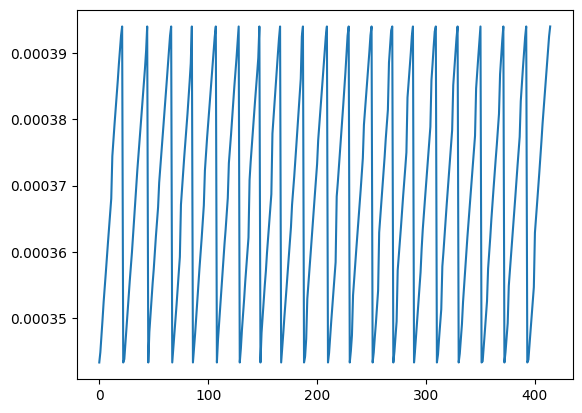

In [22]:
z_positions = [pos[2] for st in img_stacks for pos in st._info[0]['translation']]

# plot the z values
plt.plot(z_positions)

In [23]:
# make the first stack the reference stack
reference: MetaArray = img_stacks.pop(0)
reference.shape

(22, 1024, 1024)

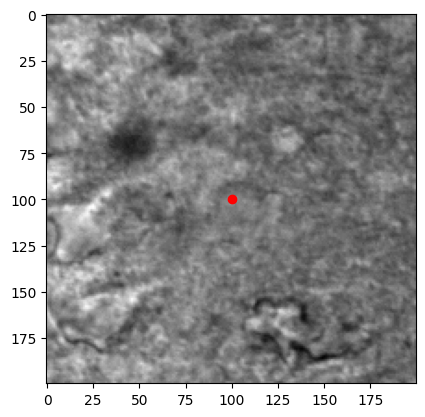

In [24]:
# display region to confirm selection

plt.imshow(reference[reference.shape[0] // 2, 414:614, 411:611], cmap='gray')
plt.scatter(100, 100, c='r')

In [25]:
trs = reference._info[0]['translation']
avg_z_step = (trs.max() - trs.min()) / len(trs)

In [26]:
from acq4.util.visual_tracker import ObjectStack, PyrLK3DTracker, CellPoseTracker

px = 3.24e-7
reference_stack = ObjectStack(
    reference.asarray(),
    px_size=px,
    z_step=avg_z_step,
    obj_center=(len(reference) // 2, *target),
)
tracker = CellPoseTracker()
tracker.set_tracked_object(reference_stack)


In [27]:
from acq4.util.visual_tracker import ImageStack

result = tracker.next_frame(reference_stack)
print(result['updated_object_stack'].obj_center)

100%|██████████| 21/21 [00:00<00:00, 408.07it/s]


[  3.96197948 514.13397707 228.95051298]


In [28]:
results = [tracker.next_frame(ImageStack(st.asarray(), px_size=px, z_step=avg_z_step)) for st in img_stacks[:10]]

100%|██████████| 19/19 [00:00<00:00, 217.73it/s]


(23, 1024, 1024) [  7 457 277]
(22, 1024, 1024) [  2 645 341]
(19, 1024, 1024) [  1 622 305]
(22, 1024, 1024) [  4 551 335]
(21, 1024, 1024) [  6 406 278]
(19, 1024, 1024) [  6 456 325]
(19, 1024, 1024) [  4 456 325]
(21, 1024, 1024) [  6 458 326]
(22, 1024, 1024) [  3 459 325]
(20, 1024, 1024) [  5 461 326]


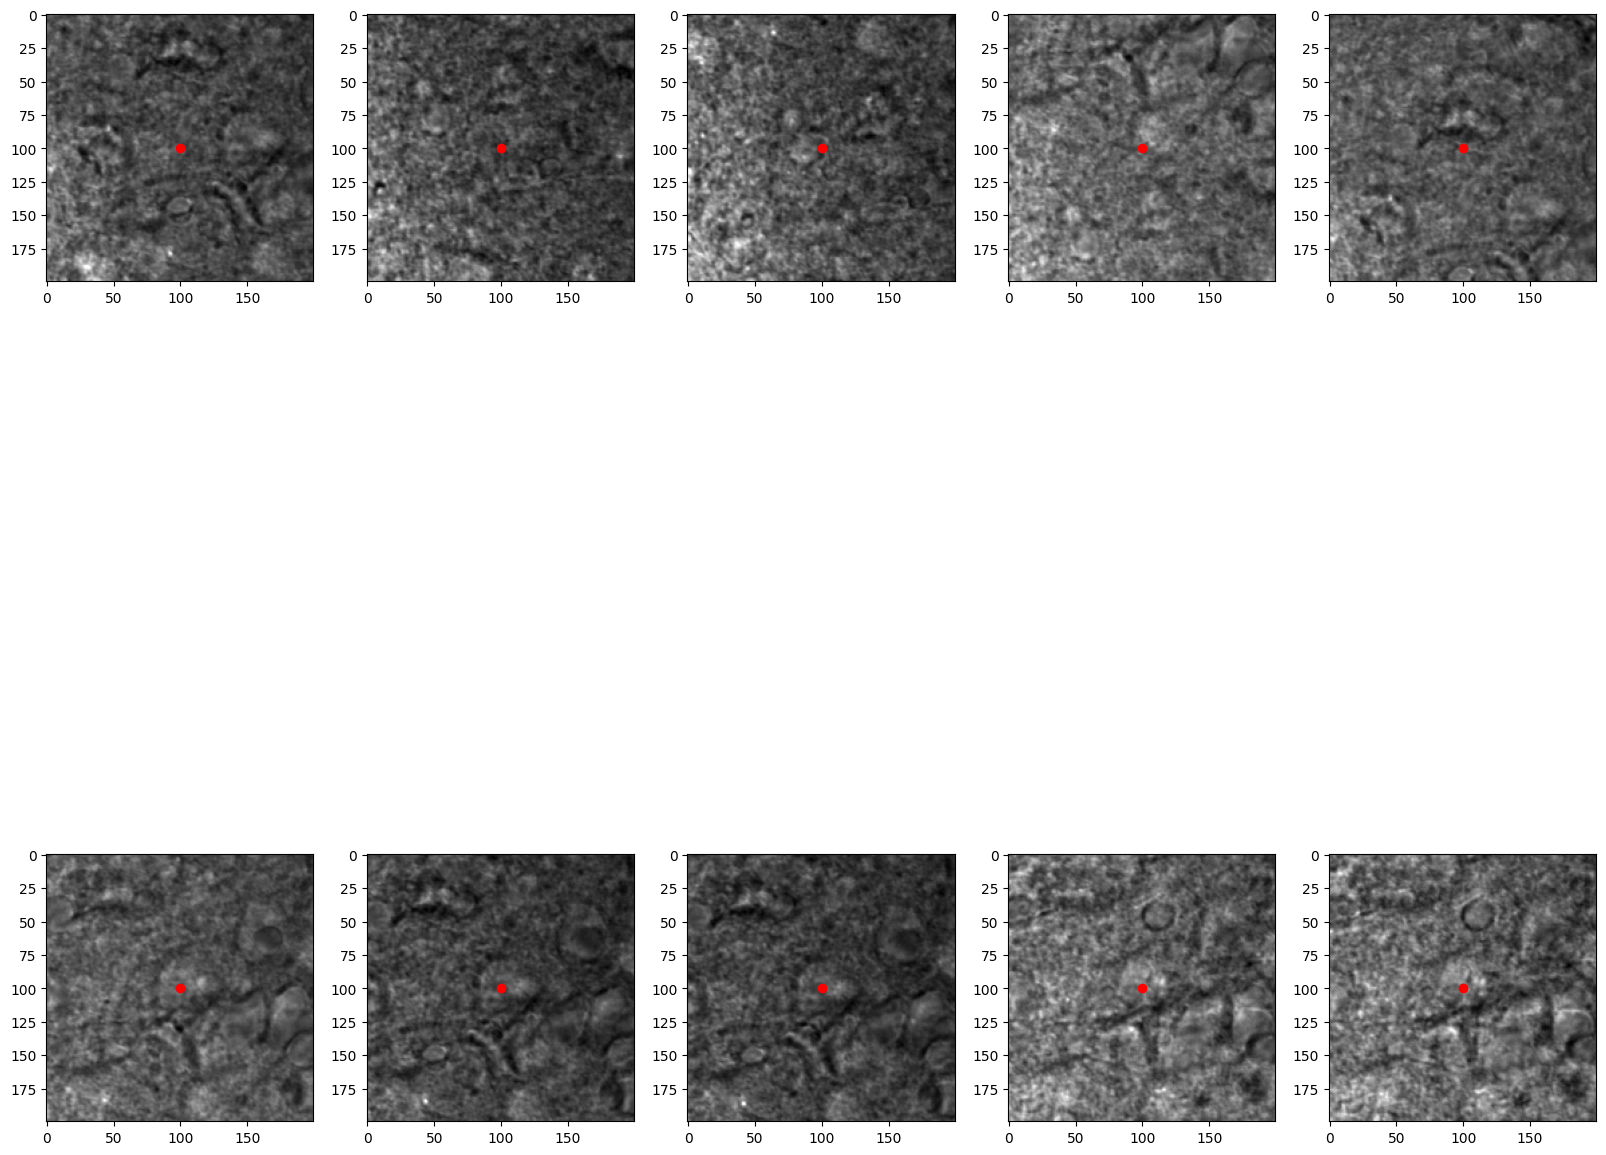

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(20, 20))
for i, r in enumerate(results):
    center = np.array(r['updated_object_stack'].obj_center).astype(int)
    r_img = r['updated_object_stack'].data
    print(r_img.shape, center)
    rmin = max(center[1] - 100, 0)
    rmax = min(center[1] + 100, r_img.shape[1])
    cmin = max(center[2] - 100, 0)
    cmax = min(center[2] + 100, r_img.shape[2])
    rgn = r_img[r_img.shape[0] // 2, rmin:rmax, cmin:cmax]
    ax[i // 5, i % 5].imshow(rgn, cmap='gray')
    ax[i // 5, i % 5].scatter(100, 100, c='r')
